<a href="https://colab.research.google.com/github/hassanjavaid07/Sample-Github-Repository/blob/main/assignment04_Hassan_MSCS23001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###<u> **GENERATIVE AI & LLM PROGRAMMING ASSIGNMENT # 4** </u>

- **NAME = HASSAN JAVAID**
- **ROLL NO. = MSCS23001**
- **TASK = Implementation of Multi-Agentic Retreival Augmented Generation (RAG) for document and search related queries**
- **LLM used: CHATGROQ WITH RAG**


* This assignment was submitted as part of course CS-500 Generative AI & LLM conducted in ITU, Lahore during Fall-2024.

* **<u>Hugging Face Space Link</u>:** [link text](https://)


* **<u>GitHub Repo Link</u>:** [link text](https://)


* This file and relavant repos are the property of the author and is under MIT License. Give credit when sharing.

### Package Installation and Environment Setup

In [ ]:
!pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
from typing import Literal
from typing_extensions import TypedDict

import json
import tqdm
import dotenv
import asyncio
import gradio as gr
from tqdm import tqdm
from datasets import Dataset
from IPython.display import display, Image, Markdown
from sklearn.metrics.pairwise import cosine_similarity

from langchain.chains import RetrievalQA
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Pinecone
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain.schema import HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent

from unstructured.partition.auto import partition
from langchain_community.tools.tavily_search import TavilySearchResults

import pinecone

# RAGAS Metrics and Evaluation
from ragas import evaluate
from ragas.metrics import faithfulness, answer_correctness


d:\new-venv\new-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
dotenv.load_dotenv()

True

### Document parsing and upserting to Pinecone

*   This section is optional if this is already done

In [ ]:
doc_fn = "NetSol_Financial Statement_2024_Part 1.pdf"

In [ ]:
elements = partition(doc_fn)
print(len(elements))

In [ ]:
print("\n\n".join([str(el) for el in elements]))

In [ ]:
docs = PyMuPDFLoader(doc_fn).load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 300,
    chunk_overlap = 0,
    length_function = len,
)

split_chunks = text_splitter.split_documents(docs)

In [ ]:
# Initialize Pinecone with API key and environment
pc = pinecone.Pinecone(
    api_key=os.environ['PINECONE_API_KEY'],  # Pinecone API Key
    environment=os.environ.get('PINECONE_ENVIRONMENT')  # Pinecone Environment
)

index_name = "gen-ai-hw4"

# Ensure the index exists
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=384,  # Dimension of the embedding model
        metric='cosine'  # Metric for similarity
    )
index = pc.Index(index_name)

# Initialize HuggingFace Embeddings
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Initialize LangChain's Pinecone vector store
vector_store = Pinecone.from_existing_index(
    index_name=index_name,
    embedding=embedding_model,  # Embedding function
    text_key="text"  # Metadata key for the original text
)

In [ ]:
# RUN ONLY ONCE FOR UPLOADING TO PINECONE
from concurrent.futures import ThreadPoolExecutor

def chunk_generator(text, chunk_size=1000, overlap=100):
    start = 0
    while start < len(text):
        chunk = text[start:start+chunk_size]
        start += chunk_size - overlap
        yield chunk

def upsert(data_batch):
    index.upsert(data_batch)

with ThreadPoolExecutor(max_workers=10) as executor:
    # Initialize tqdm progress bar
    total_chunks = sum(1 for _ in chunk_generator(elements, chunk_size=2000, overlap=100))
    with tqdm(total=total_chunks, desc="Processing chunks") as progress_bar:
        for counter, chunk in enumerate(chunk_generator(elements, chunk_size=2000, overlap=100)):
            print(f'Processing chunk {counter}')

            text_chunk = [str(el) for el in chunk]
            embeddings = embedding_model.embed_documents(text_chunk)

            # Prepare data for upsert
            data_batch = [
                {
                    'id': f'{counter}-{i}',
                    'values': embedding,
                    'metadata': {'text': text_chunk[i]}
                }
                for i, embedding in enumerate(embeddings)
            ]

            # Submit to thread pool
            executor.submit(upsert, data_batch)

            # Update the progress bar
            progress_bar.update(1)

In [ ]:
# RUN ONLY ONCE FOR UPLOADING TO PINECONE
from concurrent.futures import ThreadPoolExecutor

def upsert(data_batch):
    index.upsert(data_batch)

with ThreadPoolExecutor(max_workers=10) as executor:
    # Use tqdm to wrap the split_chunks iterable
    for counter, chunk in tqdm(enumerate(split_chunks), total=len(split_chunks), desc="Processing Chunks"):
        # print(f'Processing chunk {counter}')

        text_chunk = [str(el) for el in chunk]
        embeddings = embedding_model.embed_documents(text_chunk)

        # Prepare data for upsert
        data_batch = [
            {
                'id': f'{counter}-{i}',
                'values': embedding,
                'metadata': {'text': text_chunk[i]}
            }
            for i, embedding in enumerate(embeddings)
        ]

        # Submit to thread pool
        executor.submit(upsert, data_batch)


Processing Chunks: 100%|██████████| 1151/1151 [03:44<00:00,  5.13it/s]


In [ ]:
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 7005}},
 'total_vector_count': 7005}

#### Write structured data to text-files

In [ ]:
elements_file_path = 'structured-data/elements.txt'
split_chunks_file_path = 'structured-data/split_chunks.txt'

with open(elements_file_path, 'w', encoding='utf-8') as f_elements:
    for element in elements:
        f_elements.write(str(element) + '\n')

with open(split_chunks_file_path, 'w', encoding='utf-8') as f_chunks:
    for chunk in split_chunks:
        f_chunks.write(chunk.page_content + '\n')


### Test Retreival Chain

In [ ]:
retriever = vector_store.as_retriever(search_kwargs={"k": 3})
query = "Who is the chairman of NetSol technologies?"
retrieved_docs = retriever.get_relevant_documents(query)
for doc in retrieved_docs:
    print(doc.page_content)

C:\Users\HP\AppData\Local\Temp\ipykernel_15688\2501360083.py:3: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(query)


('page_content', 'In North America, NETSOL was a part of \ndifferent events in both the United States as \nwell as Canada. In the US, the company was \npresent at the ELFA Operations and Technol-\nogy Conference, the AFSA Annual Meeting, \nthe ELFA Annual Convention, the Auto \nFinance Summit and the Open Silicon Valley')
('page_content', 'Asia  Afrika Street No. 8, Senayan, Kebayoran Baru, South Jakarta, DKI Jakarta, 10270, Indonesia.\nThe Company is a majority owned subsidiary of NetSol Technologies Inc. USA.\n2.\nBasis of Preparation\n2.1\nSeparate financial statements')
('page_content', 'management and its employees \nacknowledge his contributions to \nfounding this company back in 1996 \nand as its foremost investor, who \nbelieved that NETSOL will change \nPakistan’s IT sector. \nSalim Ullah Ghauri\nCEO\nLahore\nSeptember 12, 2024\n23\nAnnual Report 2024\n23\nAnnual Report 2024')


In [ ]:
llm = ChatGroq(temperature=0, model_name="mixtral-8x7b-32768", api_key=os.environ['GROQ_API_KEY'])
out = llm.invoke('Hello world!')
Markdown(out.content)

Hello! I'm here to help you with any questions you have about statistics or data analysis. In the meantime, here are a few fun facts about the number "hello world" is often the first program written by people learning to code.

* The words "hello world" have been used in this context since at least 1974.
* The first edition of the book "The C Programming Language" by Brian Kernighan and Dennis Ritchie, published in 1978, includes a "hello world" program as an example.
* The tradition of using "hello world" as a first program has been adopted by many other programming languages.
* In some languages, such as Whitespace, it is possible to write a "hello world" program in just a few characters.
* In other languages, such as INTERCAL, it can take hundreds of characters to write a "hello world" program.

I hope you find these facts interesting! Let me know if you have any questions.

In [ ]:
qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)
response = qa_chain.run(query)
print(response)

C:\Users\HP\AppData\Local\Temp\ipykernel_15688\2100348777.py:2: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = qa_chain.run(query)


I don't have enough information to determine the current chairman of NetSol Technologies. The provided context includes details about NetSol's presence in North America and Asia, as well as an annual report mentioning the CEO, Salim Ullah Ghauri. However, it does not specify who the chairman is.


### System Prompt for query and query-rewrite

In [ ]:
SYS_PROMPT = """

Based on the content of your PDF document, here's a prompt to gather information:

"Gather information from the Netsol investor relations report PDF document. Please extract the following data points:

1. Financial Highlights:
	* Revenue figures for the past two years
	* Net income figures for the past two years
	* Gross profit margin percentages for the past two years
	* Total assets and liabilities figures for the past two years
2. Board of Directors and Senior Management:
	* Names and positions of the company's board of directors
	* Names and positions of the company's senior management team (including the Chairman, CEO, CFO, etc.)
3. Company Profile:
	* Overview of the company's products/services
	* Main business segments
	* Mission and vision statements
	* Brief history of the company
4. Visualizations and Graphs:
	* Identify any graphs or charts that show trends in revenue, net income, or other key financial metrics
	* Extract any information from infographics or plots that provide insights into the company's performance or industry trends
5. Financial Terms:
	* Define and provide examples of key financial terms used throughout the report (e.g., EBITDA, ROCE, etc.)
6. Images and Pictures:
	* Identify the names and roles of the company's board of directors and senior management team mentioned in the report
	* Describe any notable events or milestones mentioned in the report

Please organize the extracted information into clear and concise sections, and provide any additional context or clarifications where necessary."

"""

### Agentic Tools Definitions



*   **Tavily-search tool** for internet related queries
*   **Doc-query tool** for document related queries
*   **General tool** for general queries
*   **Math tool** was also implemented but later removed due to brevity of task



In [ ]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Add a and b.

    Args:
        a: first int
        b: second int

    Returns:
        The sum of a and b.
    """
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract b from a.

    Args:
        a: first int
        b: second int

    Returns:
        The difference of a and b.
    """
    return a - b

@tool
def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: numerator
        b: denominator

    Returns:
        The division of a by b.

    Raises:
        ValueError: If b is zero.
    """
    if b == 0:
        raise ValueError("Division by zero is not allowed.")
    return a / b

@tool
def exponentiate(a: int, b: int) -> int:
    """Raise a to the power of b.

    Args:
        a: base
        b: exponent

    Returns:
        a raised to the power of b.
    """
    return a ** b

# Tavily search tool
@tool
def search_tool(query: str, max_results: int = 3) -> str:
    """
    Perform a search query using the Tavily search tool to retrieve information.

    This function utilizes the Tavily search tool to perform a web search
    for the given query and returns the results. It is useful for answering
    questions or retrieving information from the web.

    Args:
        query: The search query string to be executed.
        max_results: The maximum number of search results
            to retrieve. Defaults to 3.

    Returns:
        str: A string containing the search results. If an error occurs during
            the search, an error message is returned instead.

    Raises:
        Exception: If there is an issue with the Tavily search tool invocation.

    Example:
        >>> search_tool("Who won the last match between Pakistan and Zimbabwe?")
        'Pakistan won the last match by 5 wickets.'
    """
    print("In search")
    tavily_search = TavilySearchResults(max_results=max_results)
    try:
        return tavily_search.invoke(query)
    except Exception as e:
        return f"Error performing search: {e}"



# Fetches document score
def scoreDocuments(docs, query, embedding_model, threshold=0.7):
    """
    Scores the relevance of documents to the query using cosine similarity.

    Args:
        docs: List of retrieved documents.
        query: The user query.
        embedding_model: Instance of HuggingFaceEmbeddings for generating embeddings.
        threshold: Minimum relevance score to consider documents relevant.

    Returns:
        bool: Whether the documents are relevant based on the threshold.
        list: List of relevance scores.
    """
    query_embedding = embedding_model.embed_query(query)
    doc_embeddings = [embedding_model.embed_query(doc.page_content) for doc in docs]
    scores = [cosine_similarity([query_embedding], [doc_embedding])[0][0] for doc_embedding in doc_embeddings]
    is_relevant = all(score >= threshold for score in scores)
    return is_relevant, scores


# Augments the prompt
def augmentPrompt(context: str, query: str) -> str:
    """
    Combines the system-level prompt with the user's query and the relevant document context.

    Args:
        context: The retrieved document context for the query.
        query: The user's original query.

    Returns:
        str: The full prompt for the LLM, including system instructions and query context.
    """
    prompt = f"""
    {SYS_PROMPT}

    The user asked: {query}

    The relevant context is:

    {context}
    """

    return prompt


# Doc-query tool
@tool
def doc_query_tool(query: str):
    """
    Fetches relevant context from Pinecone, scores relevance, and handles query refinement if needed.
    Invokes the Groq LLM for generating responses.

    Args:
        query: The user's query.

    Returns:
        str: The response generated by the LLM based on the provided or refined query.
    """
    print("In doc_query")
    retriever = vector_store.as_retriever(search_kwargs={"k": 3})
    retrieved_docs = retriever.get_relevant_documents(query)

    # Score documents for relevance
    is_relevant, scores = scoreDocuments(retrieved_docs, query, embedding_model, threshold=0.5)
    if is_relevant:
        print("In is_relevant")
        # Generate prompt with relevant context
        context = ''.join(f'## Chunk {i}:\n\n{doc.page_content}\n\n' for i, doc in enumerate(retrieved_docs))
        prompt = augmentPrompt(context, query)
        response = llm.invoke([HumanMessage(content=prompt)])
        if context:
            print("\n\n========== RESPONSE GENERATED WITH RELEVANT CONTEXT =================\n\n")
            print(f"context = {context}")
        return response
    else:
        # Rewrite the query using the LLM
        print("In query rewrite")
        chat_model = ChatGroq(temperature=0, model_name="mixtral-8x7b-32768", api_key=os.environ['GROQ_API_KEY'])
        rewrite_msg = [
            HumanMessage(
                content=f""" \n
                Look at the input and try to reason about the underlying semantic intent/meaning. \n
                Here is the initial question:
                \n ------- \n
                {query}
                \n ------- \n
                Formulate an improved question: """,
            )
        ]
        rewritten_query = chat_model.invoke(rewrite_msg)

        # # Fetch documents again with the rewritten query
        new_retrieved_docs = retriever.get_relevant_documents(rewritten_query.content)

        # Generate prompt with the new context
        new_context = ''.join(f'## Chunk {i}:\n\n{doc.page_content}\n\n' for i, doc in enumerate(new_retrieved_docs))
        new_prompt = augmentPrompt(new_context, rewritten_query.content)
        response = llm.invoke([HumanMessage(content=new_prompt)])
        if new_context:
            print("\n\n========== RESPONSE GENERATED WITH QUERY REWRITE & NEW CONTEXT =================\n\n")
            print(f"new_context = {new_context}")
        return response

@tool
def general_answer_tool(query: str):
    """Tool for handling non-specific queries (e.g., facts or definitions)."""
    print("In general")
    response = llm.invoke([HumanMessage(content=f"Answer the following general query: {query}")])
    return response

### LangGraph and Nodes/Agents setup

In [ ]:
members = ['doc_query', 'tavilysearch', 'general']
options = members + ["FINISH"]

system_prompt = """
You are a supervisor tasked with managing a conversation between the following workers: {members}.
Given the following user request, respond with the worker to act next.
Each worker will perform a task and respond with their results and status.
When finished, respond with FINISH.
"""

class Router(TypedDict):
    next: Literal['doc_query', 'tavilysearch', 'general', "FINISH"]

llm = ChatGroq(temperature=0, model_name="mixtral-8x7b-32768", api_key=os.environ['GROQ_API_KEY'])

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=options, members=", ".join(members))


# Supervisor Node Setup
def supervisor_node(state: MessagesState) -> Command[Literal['doc_query', 'tavilysearch', 'general', "__end__"]]:
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    # print(messages)
    response = llm.with_structured_output(Router).invoke(messages)
    # print(response)
    goto = response["next"]
    if goto == "FINISH":
        goto = END
    return Command(goto=goto)

# Agents Setup
# Math Agent
math_agent = create_react_agent(llm,
                                tools=[multiply, add, subtract, divide, exponentiate],
                                state_modifier="You will ONLY DO math.")

def math_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = math_agent.invoke(state)
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="math")]},
        goto="supervisor",
    )

# Search Agent
search_agent = create_react_agent(llm,
                                  tools=[search_tool],
                                  state_modifier="You are a researcher. DO NOT do any math.")

def search_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="tavilysearch")]},
        goto="supervisor",
    )

# Document Query Agent
doc_query_agent = create_react_agent(llm,
                                     tools=[doc_query_tool],
                                     state_modifier="You will only look into retreived documents for answer. DO NOT search on internet.")

def doc_query_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = doc_query_agent.invoke(state)
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="doc_query")]},
        goto="supervisor",
    )

# # General Answer Agent
general_agent = create_react_agent(llm,
                                   tools=[general_answer_tool],
                                   state_modifier="You will ONLY GIVE answer to the query if no else tool can give an answer. DO NOT do math.")

def general_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = general_agent.invoke(state)
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="general")]},
        goto="supervisor",
    )

# Build the StateGraph
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
# builder.add_node("math", math_node)
builder.add_node("tavilysearch", search_node)
builder.add_node("doc_query", doc_query_node)
builder.add_node("general", general_node)
# builder.add_edge("supervisor", END)
graph = builder.compile()

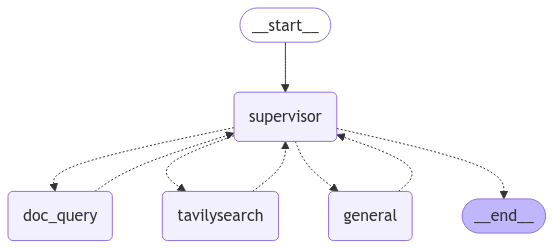

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

### Queries from json file

In [ ]:
# inputs = {"messages": [("human", "What's the sum of 5 and 10")]}
# inputs = {'messages': [('human', "What is the vision of NETSOL Technologies Limited?")]}
# inputs = {'messages': [('human', "What are the main certifications achieved by NETSOL?")]}
# inputs = {'messages': [('human', "What are the core products offered by NETSOL?")]}
inputs = {'messages': [('human', "What services does NETSOL provide?")]}
# inputs = {'messages': [('human', "What is Project Optimus at NETSOL?")]}
# inputs = {'messages': [('human', "Who is the Chairman of NETSOL Technologies?")]}
# inputs = {'messages': [('human', "Which new product developed by NETSOL targets the digital auto retail market?")]}
# inputs = {'messages': [('human', "What awards has NETSOL Technologies won?")]}
# inputs = {'messages': [('human', "Which regions does NETSOL primarily focus its marketing efforts?")]}
# inputs = {'messages': [('human', "What is the proposed cash dividend for the fiscal year 2023-2024?")]}
# inputs = {'messages': [('human', "What is the total revenue from contracts for 2024?")]}
# inputs = {'messages': [('human', "What is the main purpose of Appex Now?")]}
# inputs = {'messages': [('human', "What is the employee-related expenditure for 2024?")]}
# inputs = {'messages': [('human', "What is the location of NETSOL's registered office?")]}
# inputs = {'messages': [('human', "What is the gross profit margin for 2024?")]}
# inputs = {'messages': [('human', "What initiative has NETSOL taken for sustainability?")]}
# inputs = {'messages': [('human', "Which event marked the success of NETSOL's Otoz platform?")]}
# inputs = {'messages': [('human', "How many employees does NETSOL focus on retaining after restructuring?")]}
# inputs = {'messages': [('human', "What are the main objectives outlined in NETSOL's mission statement?")]}
# inputs = {'messages': [('human', "What is the importance of NETSOL's AI focus in 2024?")]}
# inputs = {'messages': [('human', "Who won the first T20 match between Pakistan and Zimbabwe?")]}
# inputs = {'messages': [('human', "Is Pat Gelsinger the CEO of Intel?")]}


async for chunk in graph.astream(inputs, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What services does NETSOL provide?
In doc_query
In is_relevant
context = ## Chunk 0:

NETSOL Technologies Limited NETSOL Technologies Limited

## Chunk 1:

NETSOL Technologies Limited NETSOL Technologies Limited

## Chunk 2:

NETSOL Technologies Limited


================================ Human Message =================================
Name: doc_query

NETSOL is a leading global provider of mission-critical leasing and finance software solutions. Their primary service offerings include LeasePak, a comprehensive lease and finance software solution for lessors and finance companies; NFS Ascent, a cloud-based platform for the global finance and leasing industry; NFS Agile, a flexible, end-to-end contract lifecycle management solution; and NFS Adapt, a customizable, modular solution for the finance and leasing industry.

Their services cater to various business segments, including Automotive Finance & Leasing,

In [ ]:
chunk

{'messages': [HumanMessage(content='What services does NETSOL provide?', additional_kwargs={}, response_metadata={}, id='6fdd63e1-e923-4e00-9007-5f6366b81017'),
  HumanMessage(content='NETSOL is a leading global provider of mission-critical leasing and finance software solutions. Their primary service offerings include LeasePak, a comprehensive lease and finance software solution for lessors and finance companies; NFS Ascent, a cloud-based platform for the global finance and leasing industry; NFS Agile, a flexible, end-to-end contract lifecycle management solution; and NFS Adapt, a customizable, modular solution for the finance and leasing industry.\n\nTheir services cater to various business segments, including Automotive Finance & Leasing, Equipment Finance & Leasing, Consumer Finance, Vendor Finance, and Commercial Finance.\n\nNETSOL\'s mission statement is "To be the leading global provider of business enabling software solutions to the finance and leasing industry," and their visi

In [ ]:
inputs = {"messages": [('human', "What is Project Optimus at NETSOL?")]}
for s in graph.stream(inputs, subgraphs=True):
    print(s)
    print("----")

((), {'supervisor': None})
----
In doc_query
(('doc_query:735330e7-7fd2-6f43-910c-93fbf0bf478e',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1k5e', 'function': {'arguments': '{"query":"What is Project Optimus at NETSOL?"}', 'name': 'doc_query_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 99, 'prompt_tokens': 1258, 'total_tokens': 1357, 'completion_time': 0.156538083, 'prompt_time': 0.068276606, 'queue_time': 0.00128548299999999, 'total_time': 0.224814689}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-35d535c2-b4e4-4e4d-8fe5-fa6c9ece1926-0', tool_calls=[{'name': 'doc_query_tool', 'args': {'query': 'What is Project Optimus at NETSOL?'}, 'id': 'call_1k5e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1258, 'output_tokens': 99, 'total_tokens': 1357})]}})
----
In is_relevant
(('doc_query:735330e7-7fd2-6f

### Preparation of evaluation data for RAGAS

In [ ]:
# Load llm answered data
with open("qa-answers-formatted.json", "r", encoding="utf-8") as file:
    qa_data_llm = json.load(file)

# Load the ground truth data
with open("qa-copy.json", "r", encoding="utf-8") as file:
    qa_data_gt = json.load(file)

answered_data_map = {entry["question"]: {"answer": entry["answer"], "context": entry["context"]} for entry in qa_data_llm}

evaluation_data = []
for entry in qa_data_gt:
    print(f"Processing question: {entry['question']}")
    try:
        answered_entry = answered_data_map.get(entry["question"])

        if answered_entry:
            if isinstance(answered_entry["context"], dict):
                # Convert dictionary values into a single string
                contexts = " | ".join([str(v) for v in answered_entry["context"].values()])
            else:
                contexts = answered_entry["context"]

            evaluation_data.append({
                "question": entry["question"],
                "ground_truth": entry["answer"],
                "answer": answered_entry["answer"],
                "retrieved_contexts": [contexts]
            })
        else:
            print(f"No matching answer found for question: {entry['question']}")
    except Exception as e:
        print(f"Error processing question: {entry['question']} - {e}")

print(f"Prepared {len(evaluation_data)} evaluation entries.")


In [ ]:
evaluation_data

[{'question': 'What is the vision of NETSOL Technologies Limited?',
  'ground_truth': 'To become the leading and world-class provider of IT solutions and services in each market of operations by leveraging global positioning, creating strong growth potential, increasing shareholder value, and providing a great environment for employees.',
  'answer': "Based on the information provided, the vision of NETSOL Technologies Limited is not explicitly stated. However, the company's mission statement is to be the world's leading provider of business services and solutions to the asset finance and leasing industry. It can be inferred that the company aspires to be a global leader in providing business services and solutions to the asset finance and leasing industry, leveraging its cutting-edge technology and domain expertise.",
  'retrieved_contexts': ['NETSOL Technologies Limited | NETSOL Technologies Limited | NETSOL Technologies Limited NETSOL Technologies Limited']},
 {'question': 'What are

In [ ]:
evaluation_data[0]

{'question': 'What is the vision of NETSOL Technologies Limited?',
 'ground_truth': 'To become the leading and world-class provider of IT solutions and services in each market of operations by leveraging global positioning, creating strong growth potential, increasing shareholder value, and providing a great environment for employees.',
 'answer': "Based on the information provided, the vision of NETSOL Technologies Limited is not explicitly stated. However, the company's mission statement is to be the world's leading provider of business services and solutions to the asset finance and leasing industry. It can be inferred that the company aspires to be a global leader in providing business services and solutions to the asset finance and leasing industry, leveraging its cutting-edge technology and domain expertise.",
 'retrieved_contexts': ['NETSOL Technologies Limited | NETSOL Technologies Limited | NETSOL Technologies Limited NETSOL Technologies Limited']}

### Ragas Metrics Calculation

In [ ]:
# Convert the flattened data into a Dataset
dataset = Dataset.from_list([evaluation_data[0]])
print(dataset)

Dataset({
    features: ['question', 'ground_truth', 'answer', 'retrieved_contexts'],
    num_rows: 1
})


In [ ]:
dataset.shape

(1, 4)

In [ ]:
metrics = [faithfulness, answer_correctness]

result = evaluate(dataset, metrics=metrics)

df = result.to_pandas()

Evaluating: 100%|██████████| 2/2 [02:47<00:00, 83.87s/it] 


In [ ]:
df

,user_input,retrieved_contexts,response,reference,faithfulness,answer_correctness
0,What is the vision of NETSOL Technologies Limi...,[NETSOL Technologies Limited | NETSOL Technolo...,"Based on the information provided, the vision ...",To become the leading and world-class provider...,NaN,NaN


### Gradio App Creation

In [ ]:
def convertQueryToInputsFormat(query):
    return {"messages": [('human', query)]}


async def getFinalGraphResponse(graph, inputs, stream_mode="values"):
    final_chunk = None
    async for chunk in graph.astream(inputs, stream_mode=stream_mode):
        final_chunk = chunk
    return final_chunk

def getResponse(input_text):
    inputs = convertQueryToInputsFormat(input_text)
    try:
        loop = asyncio.get_event_loop()
    # Handle cases where no loop exists
    except RuntimeError:
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)

    final_output = loop.run_until_complete(getFinalGraphResponse(graph, inputs))

    if final_output and "messages" in final_output:
        response = final_output["messages"][-1].content
        return response
    else:
        return "No response received."

# Create the Gradio Interface
iface = gr.Interface(
    fn=getResponse,
    inputs=gr.Textbox(
        label="Enter your question",
        placeholder="Type your question here..."
    ),
    outputs="textbox",
    title="Researcher and Doc-Query Handler",
    description=(
        "Ask a question about NetSol Financial Report or internet related query "
        "This assistant looks up relevant documents if needed and then answers your question."
    ),
    examples=[
        ["What are the main objectives outlined in NETSOL's mission statement?"],
        ["Who won first t20 match between Pakistan and Zimbabwe?"],
        ["Who is the CEO of Huawei?"]
    ],
    theme=gr.themes.Soft(),
    allow_flagging="never"
)

iface.launch(share=False)


d:\new-venv\new-env\Lib\site-packages\gradio\interface.py:399: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


In doc_query
In is_relevant


========== RESPONSE GENERATED WITH RELEVANT CONTEXT =================


context = ## Chunk 0:

('page_content', 'benefits of superior digital solutions across various touchpoints which can be integrated with any \nback-end system. NETSOL takes pride in being the pioneer organization to provide a full suite of \ndigital transformation solutions for the global asset finance and leasing industry.')

## Chunk 1:

('page_content', 'demands of the company’s diverse global \nclient base. NETSOL’s focus includes harness-\ning emerging technologies, including but not \nlimited to, AI, ML and data analytics, to create \nsolutions that enhance efficiency and elevate \nuser experiences. \nAs a global leader in the provision of tech-')

## Chunk 2:

('page_content', 'strategic initiatives, NETSOL is confident in its \nability to sustain growth, provide substantial \nvalue to stakeholders and uphold its position \nas a leading technology provider to the global \nasset f

In [ ]:
# End of code